In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
dat = pd.read_csv("data/load_weather_energy_hourly_2018.csv")
dat.time = pd.to_datetime(dat.time)
dat.set_index('time',inplace=True)

In [3]:
grouped_sum = dat.groupby('time')["base_demand"].sum().reset_index()
grouped_sum = grouped_sum.rename(columns={'base_demand': 'total_base_demand'})

In [4]:
result = dat.merge(grouped_sum, on='time', how='left')
result['share_by_hour'] = result['base_demand']/result['total_base_demand']

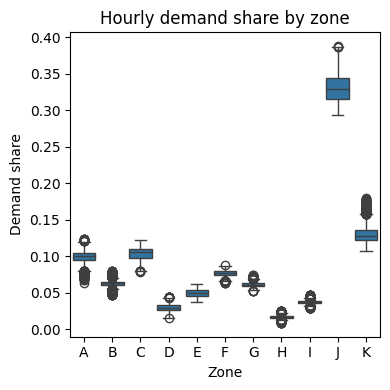

In [5]:
plt.figure(figsize=(4, 4))
sns.boxplot(x='zone', y='share_by_hour', data=result)
plt.title('Hourly demand share by zone')
plt.xlabel('Zone')
plt.ylabel('Demand share')
plt.tight_layout()
plt.show()

In [6]:
result['heating'] = result['stock_demand'] * result['share_by_hour']
result['base_demand_and_heating'] = result['base_demand'] + result['heating']

In [7]:
result.set_index('time',inplace=True)

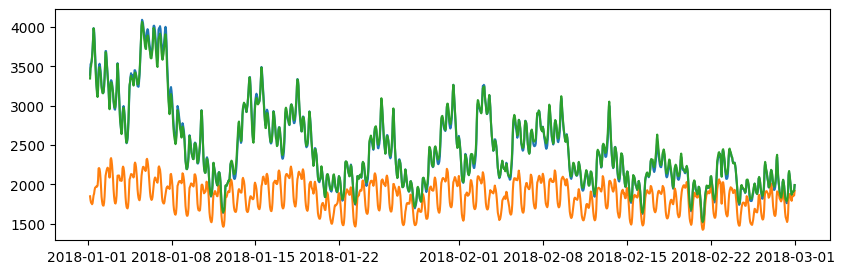

In [8]:
df_to_plot = result['2018-01-01':'2018-02-28']
df_to_plot = df_to_plot[df_to_plot["zone"]=="A"]

plt.figure(figsize=(10, 3))
plt.plot(df_to_plot.total_load)
plt.plot(df_to_plot.base_demand)
plt.plot(df_to_plot.base_demand_and_heating)
plt.show()

In [9]:
grouped_data = result.groupby('zone').agg({
    'heating': [ 'max'],
    'stock_demand_share': [ 'max']
    }).reset_index()

# Step 2: Flatten the multi-level column names to make them easier to work with
grouped_data.columns = ['_'.join(col).strip('_') if col[1] != '' else col[0] for col in grouped_data.columns.values]
grouped_data

,zone,heating_max,stock_demand_share_max
0,A,2126.196113,2130.826339
1,B,1334.949623,1351.155224
2,C,2459.722227,2215.028172
3,D,775.574845,758.299995
4,E,1272.263043,1049.128635
5,F,1864.680729,1598.036214
6,G,1508.090563,1368.315662
7,H,471.884275,374.386545
8,I,777.629575,826.663664
9,J,6647.751705,7165.700927


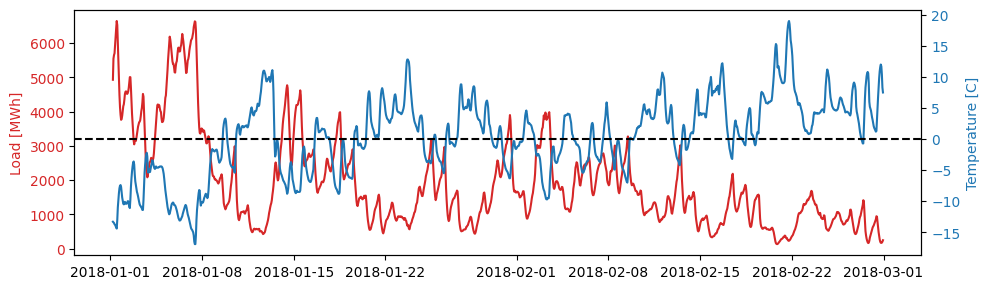

In [26]:
fig, ax1 = plt.subplots(figsize=(10, 3))
temp = result['2018-01-01':'2018-02-28']
temp = temp[temp["zone"]=="J"]

color = 'tab:red'
ax1.set_ylabel('Load [MWh]', color=color)
ax1.plot(temp.heating, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Temperature [C]', color=color)  # we already handled the x-label with ax1
ax2.plot(temp.temp_solar, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.axhline(0,linestyle="--",color="black")
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

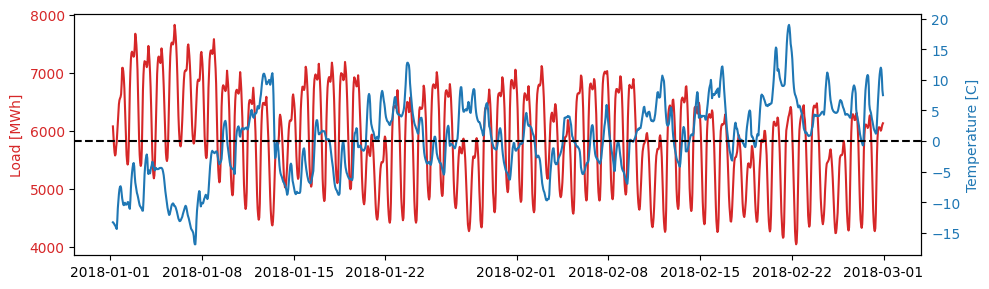

In [25]:
fig, ax1 = plt.subplots(figsize=(10, 3))
temp = result['2018-01-01':'2018-02-28']
temp = temp[temp["zone"]=="J"]

color = 'tab:red'
ax1.set_ylabel('Load [MWh]', color=color)
ax1.plot(temp.base_demand, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Temperature [C]', color=color)  # we already handled the x-label with ax1
ax2.plot(temp.temp_solar, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.axhline(0,linestyle="--",color="black")

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

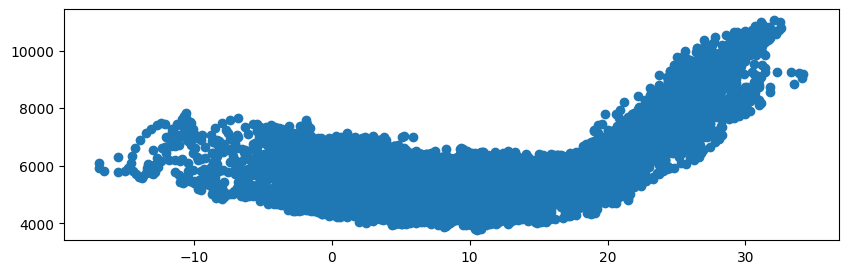

In [12]:
fig, ax1 = plt.subplots(figsize=(10, 3))
temp = result['2018-01-10':'2018-01-30'][['zone','base_demand','temp_solar','base_demand_and_heating']]
temp = result[result["zone"]=="J"]

plt.scatter(temp.temp_solar,temp.base_demand)

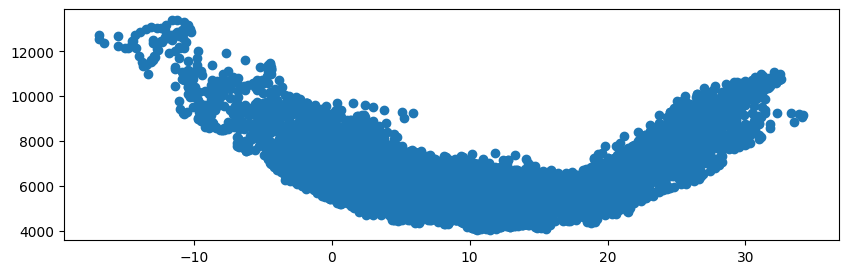

In [13]:
fig, ax1 = plt.subplots(figsize=(10, 3))
temp = result['2018-01-10':'2018-01-30'][['zone','base_demand','temp_solar','base_demand_and_heating']]
temp = result[result["zone"]=="J"]

plt.scatter(temp.temp_solar,temp.base_demand_and_heating)

In [14]:
result["base_load_2036"] = result["base_demand"] * 1.21
result["load_2036"] = result["base_load_2036"] + result["heating"]

In [15]:
df = result
df["season"] = "winter"
df.loc['2018-05-01':'2018-10-31','season'] = "summer"

In [16]:
total_load_2036 = result.groupby(['time','season']).agg({'load_2036': ['sum']})
total_load_2036.groupby('season').max()

,load_2036
,sum
season,
summer,38562.528341
winter,47378.266259


In [17]:
total_load_2036["load_2036"]["sum"].sum()/1000

np.float64(213976.1902094752)

In [18]:
total_load_2036.columns = ['_'.join(col).strip('_') if col[1] != '' else col[0] for col in total_load_2036.columns.values]


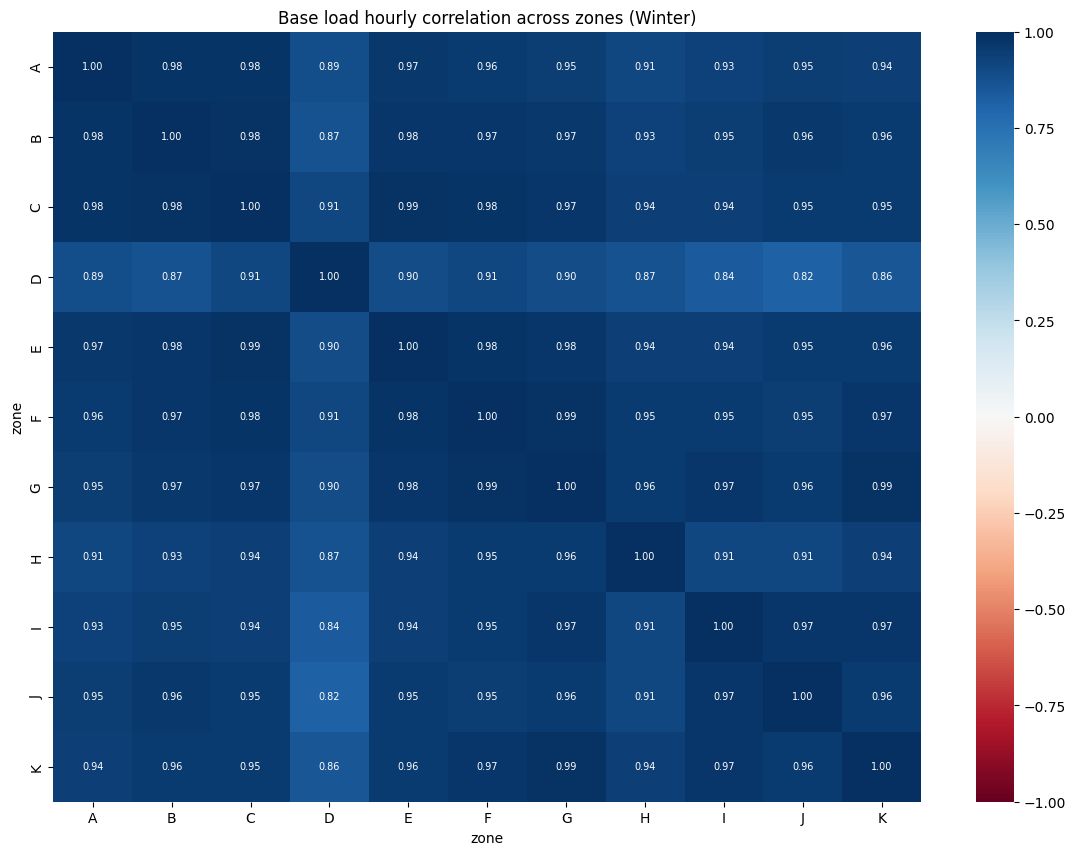

In [19]:
corr_matrix = df[df.season=="winter"].pivot_table(index='time',columns='zone',values='base_demand_and_heating').reset_index()
corr_matrix = corr_matrix.drop(['time'],axis=1,inplace=False).corr()
plt.figure(figsize=(14,10))
ax = sns.heatmap(corr_matrix,
            vmax=1, vmin=-1,
            annot=True, fmt=".2f",annot_kws={'fontsize':7},
            cmap="RdBu")
ax.set_title('Base load hourly correlation across zones (Winter)')
plt.show()

In [20]:
total_load_2036.reset_index(inplace=True)
total_load_2036

,time,season,load_2036_sum
0,2018-01-01 05:00:00+00:00,winter,39359.675228
1,2018-01-01 06:00:00+00:00,winter,40576.096231
2,2018-01-01 07:00:00+00:00,winter,40408.220017
3,2018-01-01 08:00:00+00:00,winter,40342.122487
4,2018-01-01 09:00:00+00:00,winter,41059.833682
...,...,...,...
8750,2018-12-31 19:00:00+00:00,winter,25321.326116
8751,2018-12-31 20:00:00+00:00,winter,25457.804279
8752,2018-12-31 21:00:00+00:00,winter,26453.509371
8753,2018-12-31 22:00:00+00:00,winter,27200.245136


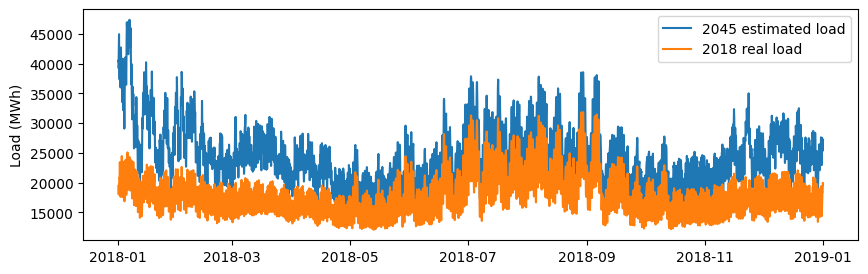

In [21]:
plt.figure(figsize=(10, 3))
plt.plot(total_load_2036['time'],total_load_2036['load_2036_sum'],label="2045 estimated load")
plt.plot(result.groupby("time")["base_demand"].sum(),label="2018 real load")
plt.legend()
plt.ylabel("Load (MWh)")
plt.show()